<a href="https://colab.research.google.com/github/seravatpendragon/cats-and-dogs/blob/main/Cats_and_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Limpando instalações anteriores...
Fazendo download do dataset...
Download concluído!
Extraindo o arquivo...
Extração concluída!

Verificando diretório base: /tmp/cats_and_dogs_filtered
Diretório existe: True
Conteúdo do diretório base:
['vectorize.py', 'validation', 'train']

Verificando diretório de treino: /tmp/cats_and_dogs_filtered/train
Diretório existe: True
Conteúdo do diretório de treino:
['dogs', 'cats']

Verificando subdiretório cats: /tmp/cats_and_dogs_filtered/train/cats
Diretório existe: True
Número de imagens de gatos: 1000

Verificando subdiretório dogs: /tmp/cats_and_dogs_filtered/train/dogs
Diretório existe: True
Número de imagens de cachorros: 1000

Verificando diretório de validação: /tmp/cats_and_dogs_filtered/validation
Diretório existe: True
Conteúdo do diretório de validação:
['dogs', 'cats']

Criando datasets...
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Classes: ['cats', 'dogs']
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us

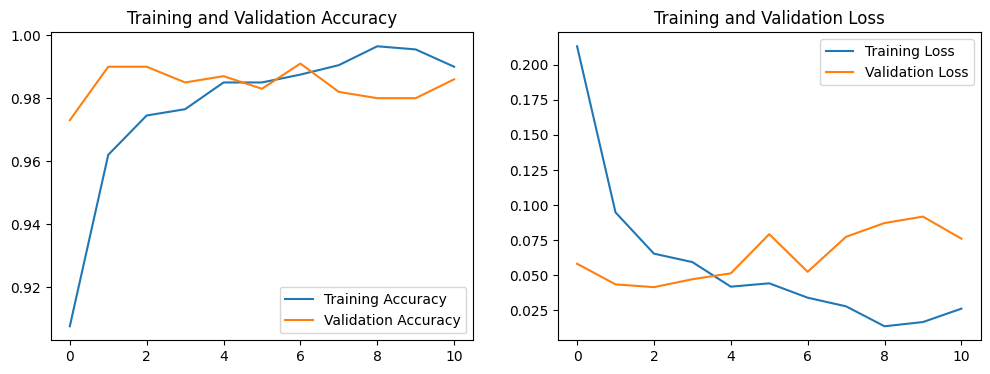

Modelo salvo com sucesso!


In [7]:
# ==============================================================================
# SOLUÇÃO ROBUSTA PARA O PROBLEMA DE DOWNLOAD E CARREGAMENTO
# ==============================================================================

# Importar bibliotecas necessárias
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
import requests

# 1. Limpar qualquer instalação anterior
print("Limpando instalações anteriores...")
!rm -rf /tmp/cats_and_dogs_filtered
!rm -f /tmp/cats_and_dogs_filtered.zip

# 2. Download manual do arquivo
print("Fazendo download do dataset...")
url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
response = requests.get(url)
with open('/tmp/cats_and_dogs_filtered.zip', 'wb') as f:
    f.write(response.content)
print("Download concluído!")

# 3. Extração manual do arquivo
print("Extraindo o arquivo...")
with zipfile.ZipFile('/tmp/cats_and_dogs_filtered.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp')
print("Extração concluída!")

# 4. Verificar a estrutura de diretórios
base_dir = '/tmp/cats_and_dogs_filtered'
print(f"\nVerificando diretório base: {base_dir}")
print(f"Diretório existe: {os.path.exists(base_dir)}")

if os.path.exists(base_dir):
    print("Conteúdo do diretório base:")
    print(os.listdir(base_dir))

    train_dir = os.path.join(base_dir, 'train')
    validation_dir = os.path.join(base_dir, 'validation')

    print(f"\nVerificando diretório de treino: {train_dir}")
    print(f"Diretório existe: {os.path.exists(train_dir)}")

    if os.path.exists(train_dir):
        print("Conteúdo do diretório de treino:")
        print(os.listdir(train_dir))

        cats_dir = os.path.join(train_dir, 'cats')
        dogs_dir = os.path.join(train_dir, 'dogs')

        print(f"\nVerificando subdiretório cats: {cats_dir}")
        print(f"Diretório existe: {os.path.exists(cats_dir)}")
        if os.path.exists(cats_dir):
            print(f"Número de imagens de gatos: {len(os.listdir(cats_dir))}")

        print(f"\nVerificando subdiretório dogs: {dogs_dir}")
        print(f"Diretório existe: {os.path.exists(dogs_dir)}")
        if os.path.exists(dogs_dir):
            print(f"Número de imagens de cachorros: {len(os.listdir(dogs_dir))}")

    print(f"\nVerificando diretório de validação: {validation_dir}")
    print(f"Diretório existe: {os.path.exists(validation_dir)}")

    if os.path.exists(validation_dir):
        print("Conteúdo do diretório de validação:")
        print(os.listdir(validation_dir))

# 5. Parâmetros do dataset
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# 6. Criar datasets (apenas se os diretórios existirem)
if os.path.exists(train_dir) and os.path.exists(validation_dir):
    print("\nCriando datasets...")

    # Criar datasets de treino
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        shuffle=True,
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE)

    # Criar datasets de validação
    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        validation_dir,
        shuffle=True,
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE)

    # Verificar os nomes das classes
    class_names = train_dataset.class_names
    print("Classes:", class_names)

    # 7. Configurar dataset para performance
    AUTOTUNE = tf.data.AUTOTUNE
    train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
    validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

    # 8. Data augmentation
    data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ])

    # 9. Preprocess input
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

    # 10. Criar modelo base
    IMG_SHAPE = IMG_SIZE + (3,)
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=IMG_SHAPE,
        include_top=False,
        weights='imagenet')
    base_model.trainable = False

    # 11. Construir modelo completo
    inputs = keras.Input(shape=IMG_SHAPE)
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)

    # 12. Compilar modelo
    base_learning_rate = 0.001
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

    # 13. Treinar modelo
    print("\nIniciando treinamento...")
    initial_epochs = 10
    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=initial_epochs)

    # 14. Fine-tuning
    print("\nIniciando fine-tuning...")
    base_model.trainable = True
    fine_tune_at = 100
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

    fine_tune_epochs = 10
    total_epochs = initial_epochs + fine_tune_epochs

    history_fine = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=total_epochs,
        initial_epoch=history.epoch[-1])

    # 15. Avaliar modelo
    loss, accuracy = model.evaluate(validation_dataset)
    print(f'\nAcurácia final de validação: {accuracy:.4f}')

    # 16. Plotar resultados
    def plot_history(history):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(acc, label='Training Accuracy')
        plt.plot(val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(loss, label='Training Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.show()

    plot_history(history_fine)

    # 17. Salvar modelo
    model.save('cats_dogs_classifier.h5')
    print("Modelo salvo com sucesso!")

else:
    print("\nERRO: Não foi possível criar os diretórios necessários!")
    print("Por favor, verifique se o download foi concluído corretamente.")